# Visualize the four base proximity graphs in 2D

C:\Users\Neiko\miniconda3\envs\city2graph\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


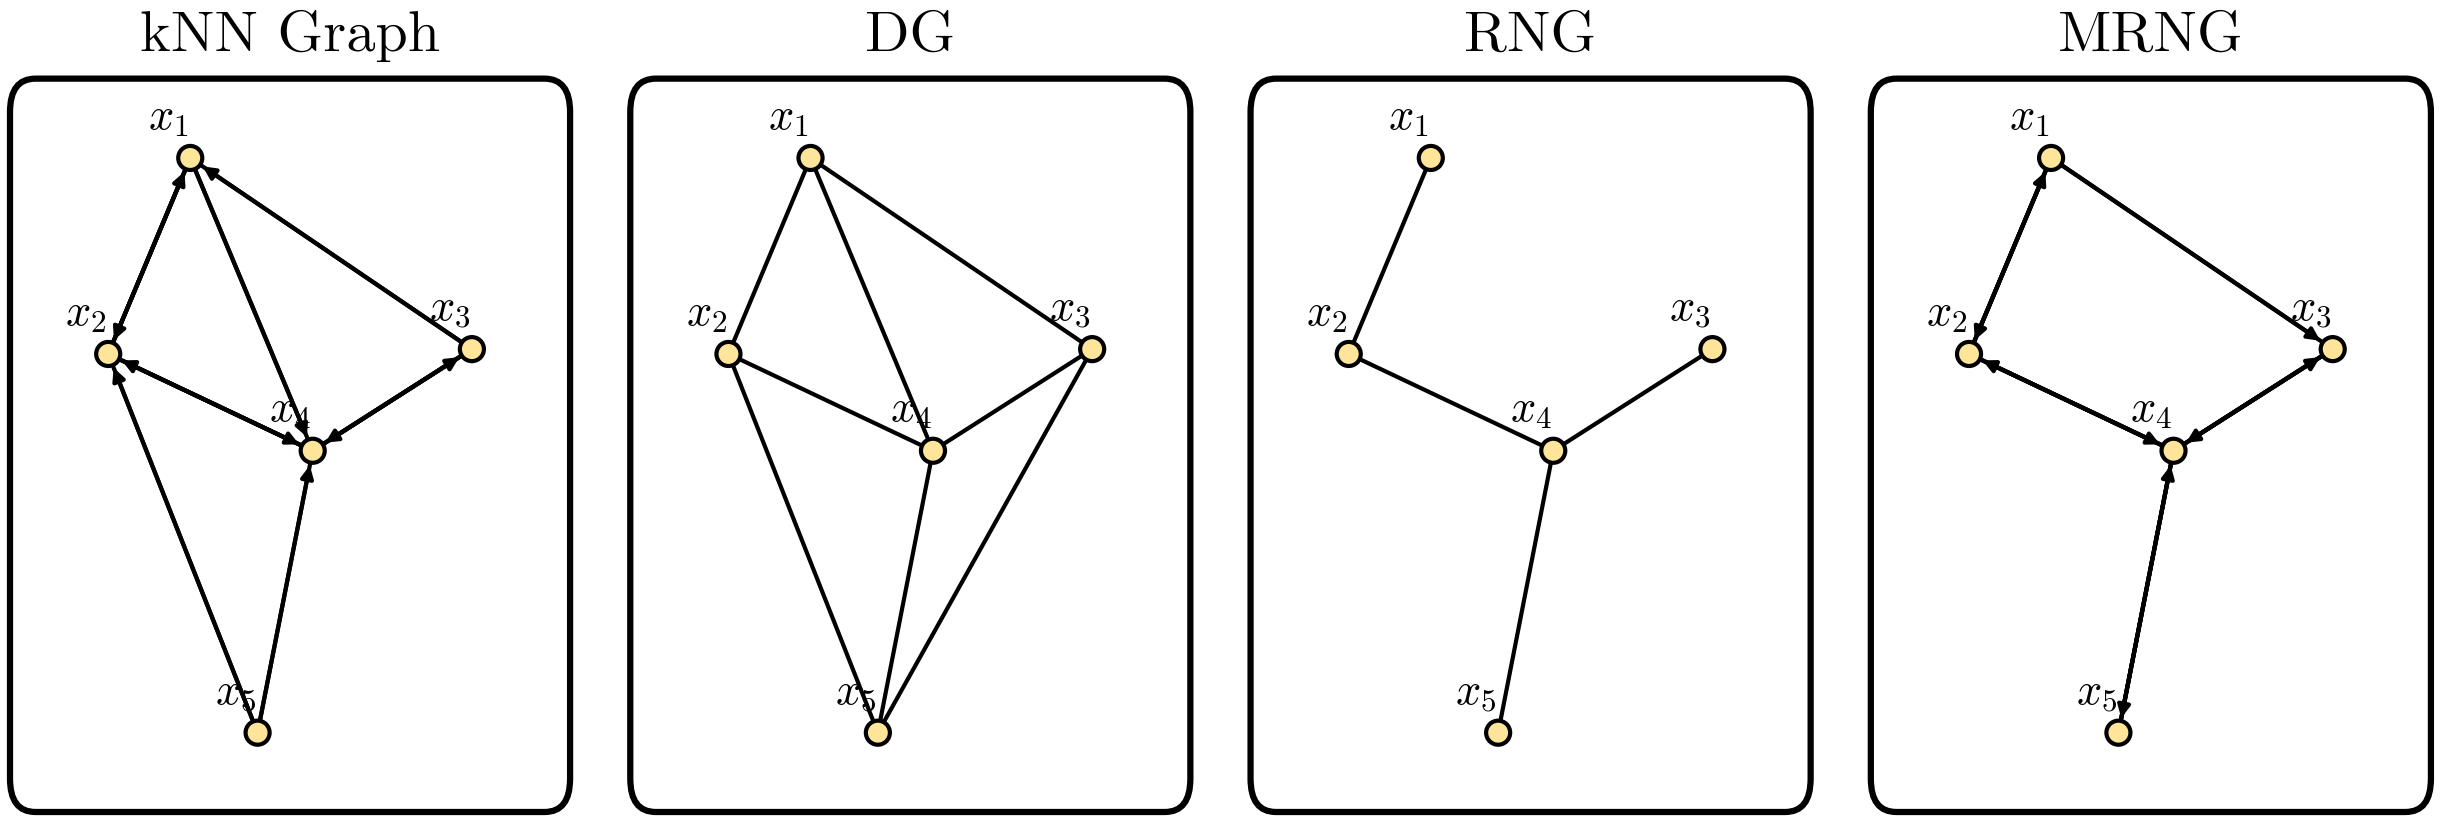

In [1]:
from plot import plot_graphs
from graphs import GraphKind, build_graphs
from utils import create_coords

coords = create_coords([[12.3,-3.6],[5.6,-19.8],[35.3,-19.4],[22.3,-27.8],[17.8,-51.1]])

# gdf: your GeoDataFrame with a 'features' column and point 'geometry'
# Build all graph kinds (base + DEG) with a chosen edges_per_vertex
all_kinds = [GraphKind.KNN, GraphKind.DG, GraphKind.RNG, GraphKind.MRNG]
graphs = build_graphs(coords, kinds=all_kinds, edges_per_vertex=2)

# Example usage
plot_graphs(graphs=graphs, bg_color="white", text_color="black", annotation_size=32, title_size=42, marker_size=300, border_color="black", border_padding_x=20, edge_width=3, max_per_row=4, save_file="base_proximity_graphs.pdf")

# Colorize the edges of DEG based on the base graphs

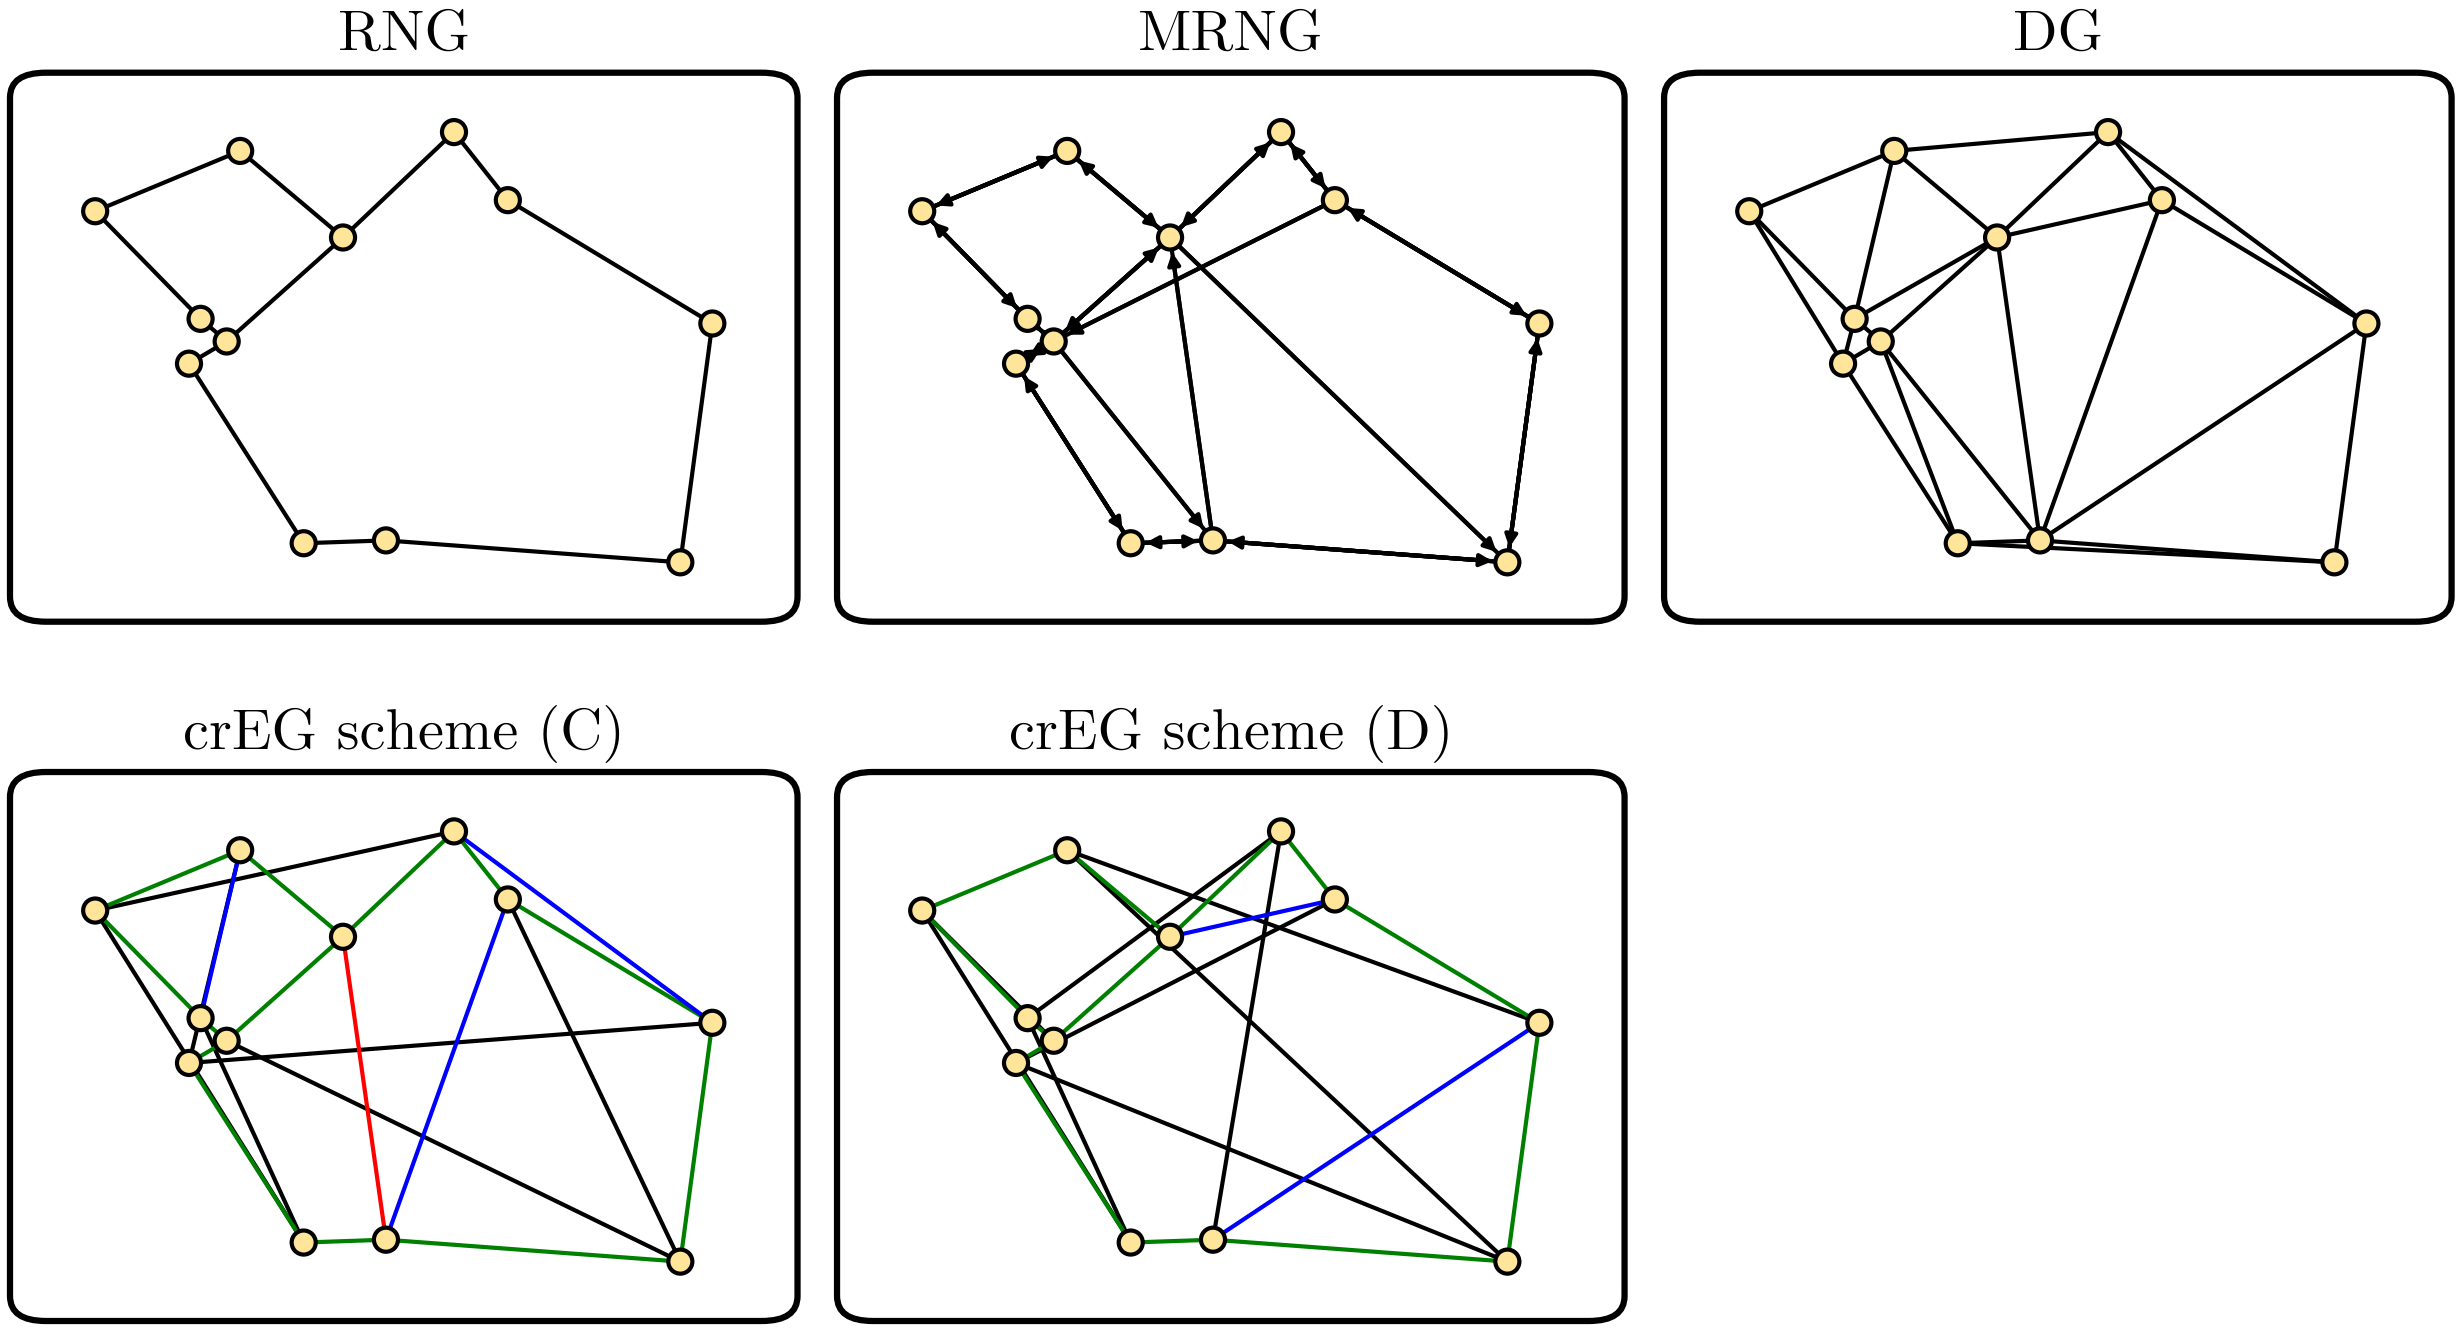

In [2]:
from plot import plot_graphs
from utils import create_random_coords
from graphs import GraphItem, GraphKind, build_graphs
from evaluate import color_overlapping_edges

def color_graph(deg, dg, mrng, rng):
    colored_edges = deg.edges.copy()
    color_overlapping_edges(dg.edges, colored_edges, color="blue", inplace=True)
    color_overlapping_edges(mrng.edges, colored_edges, color="red", inplace=True)
    color_overlapping_edges(rng.edges, colored_edges, color="green", inplace=True)

    # Sync back to the GraphItem so plots reflect the updated colors
    return GraphItem(deg.kind, deg.title, False, deg.vertices, colored_edges)

graph_kinds = [GraphKind.DG, GraphKind.MRNG, GraphKind.RNG, GraphKind.DEGStream, GraphKind.DEGHigh, GraphKind.DEGLow]

coords = create_random_coords(n=12, scale=50, seed=7)
graphs = build_graphs(coords, kinds=graph_kinds, edges_per_vertex=4)

colored_stream_edges = color_graph(graphs[3], graphs[0], graphs[1], graphs[2])
colored_high_edges = color_graph(graphs[4], graphs[0], graphs[1], graphs[2])
colored_low_edges = color_graph(graphs[5], graphs[0], graphs[1], graphs[2])

colored_graphs = [graphs[2], graphs[1], graphs[0], colored_low_edges, colored_high_edges]
plot_graphs(graphs=colored_graphs, bg_color="white", text_color="black", annotation_size=0, title_size=42, marker_size=300, border_color="black", edge_width=3, max_per_row=3, save_file="crEG_edges_colored.pdf")

# Visualize the crEG basics

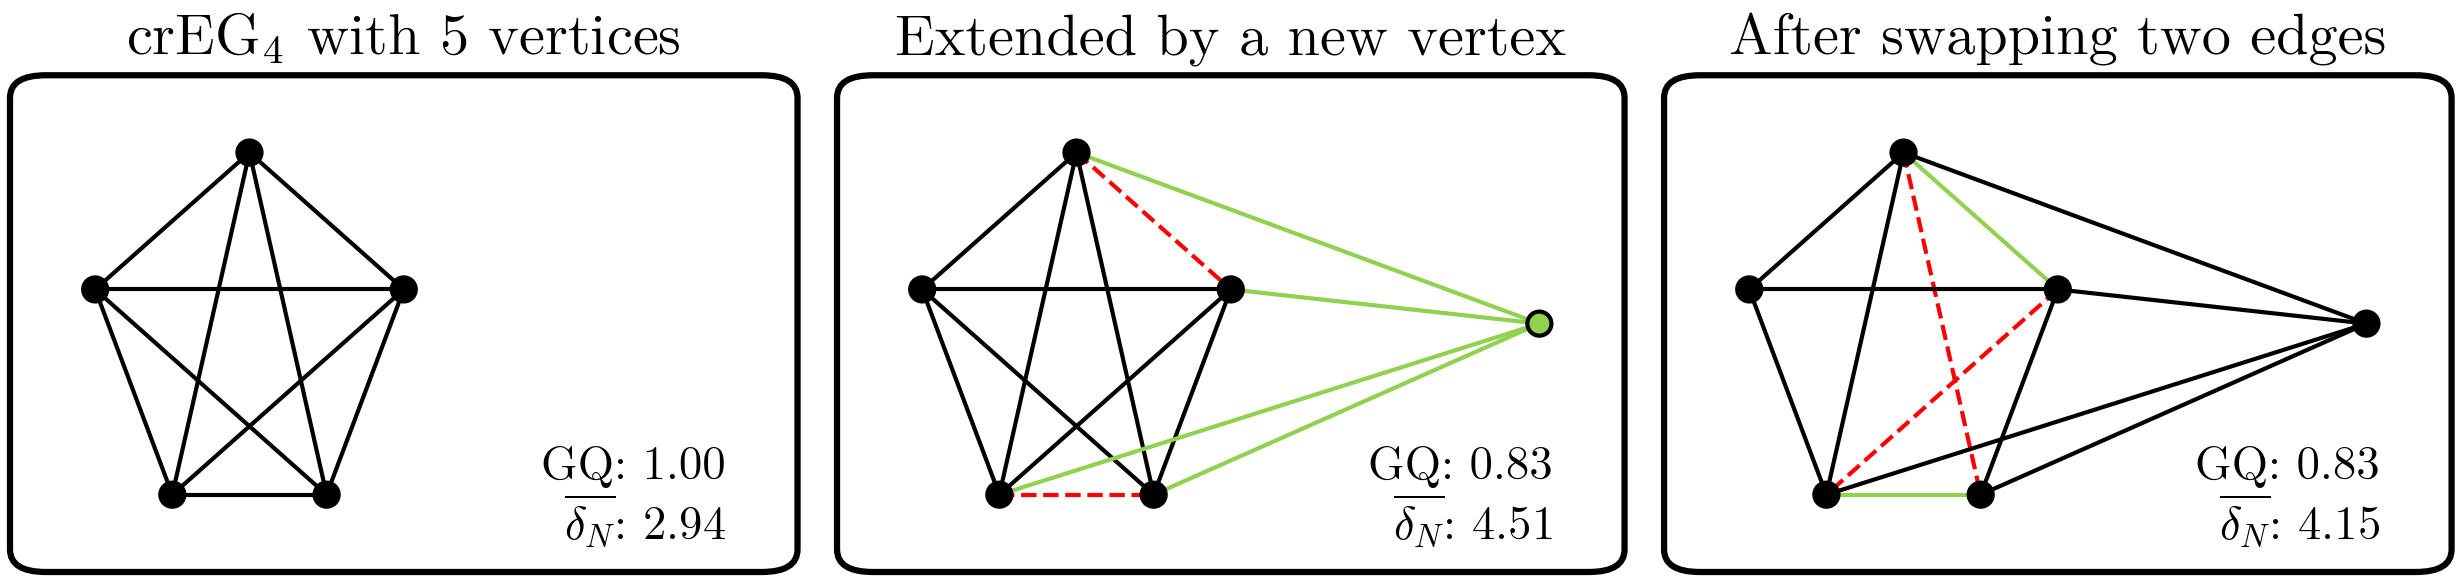

In [7]:
import geopandas as gpd
from shapely.geometry import LineString, Point
import numpy as np
from graphs import GraphItem
from plot import plot_graphs
from utils import create_coords

# Helper function to create a GeoDataFrame for edges.
def create_edges_gdf(coords_df, edges_spec):
    """
    Create a GeoDataFrame for edges from a specification list.
    edges_spec: list of (source_id, target_id, color, linestyle) tuples.
    """
    rows = []
    coords_list = [np.array(p.coords[0]) for p in coords_df['geometry']]
    for src, tgt, color, linestyle in edges_spec:
        p1 = coords_list[src]
        p2 = coords_list[tgt]
        geom = LineString([p1, p2])
        weight = np.linalg.norm(p1 - p2)
        rows.append({
            'source': src,
            'target': tgt,
            'geometry': geom,
            'weight': weight,
            'color': color,
            'linestyle': linestyle
        })
    return gpd.GeoDataFrame(rows, columns=['source', 'target', 'geometry', 'weight', 'color', 'linestyle'])


# --- Shared Data ---
# Define vertex coordinates to match the visual layout
coords = [
    (2, 5),    # 0: top
    (0, 3),    # 1: mid-left
    (4, 3),    # 2: mid-right
    (1, 0),    # 3: bottom-left
    (3, 0),    # 4: bottom-right
    (8, 2.5)   # 5: new vertex (far right)
]
light_green = '#92d050'
red_color = '#ff0000'

# --- Graph 1: "DEG4 with 5 vertices" ---
vertices1 = create_coords(coords[0:5])
vertices1['color'] = 'black'
k5_edges_spec = [(i, j, 'black', 'solid') for i in range(5) for j in range(i + 1, 5)]
edges1 = create_edges_gdf(vertices1, k5_edges_spec)

graph1 = GraphItem(
    kind=None,
    is_directed=False,
    title=r"crEG$_4$ with 5 vertices",
    vertices=vertices1,
    edges=edges1,
    annotations=["GQ: 1.00", r"$\overline{\delta_N}$: 2.94"]
)

# --- Graph 2: "Extended by a new vertex" ---
vertices2 = create_coords(coords)
vertices2['color'] = 'black'
vertices2.loc[5, 'color'] = light_green
edges2_spec = [spec for spec in k5_edges_spec if (spec[0], spec[1]) != (0, 2) and (spec[0], spec[1]) != (3, 4)]
edges2_spec.append((0, 2, red_color, 'dashed'))
edges2_spec.append((3, 4, red_color, 'dashed'))
for target_id in [0, 2, 3, 4]:
    edges2_spec.append((5, target_id, light_green, 'solid'))
edges2 = create_edges_gdf(vertices2, edges2_spec)

graph2 = GraphItem(
    kind=None,
    is_directed=False,
    title="Extended by a new vertex",
    vertices=vertices2,
    edges=edges2,
    annotations=["GQ: 0.83", r"$\overline{\delta_N}$: 4.51"]
)

# --- Graph 3: "After swapping two edges" ---
vertices3 = create_coords(coords)
vertices3['color'] = 'black'
edges3_spec = [
    (0, 4, red_color, 'dashed'), (2, 3, red_color, 'dashed'),
    (0, 2, light_green, 'solid'), (3, 4, light_green, 'solid'),
    (0, 1, 'black', 'solid'), (0, 3, 'black', 'solid'),
    (1, 2, 'black', 'solid'), (1, 3, 'black', 'solid'), (2, 4, 'black', 'solid'),
    (5, 0, 'black', 'solid'), (5, 3, 'black', 'solid'),
    (5, 2, 'black', 'solid'), (5, 4, 'black', 'solid'),
]
edges3 = create_edges_gdf(vertices3, edges3_spec)

graph3 = GraphItem(
    kind=None,
    is_directed=False,
    title="After swapping two edges",
    vertices=vertices3,
    edges=edges3,
    annotations=["GQ: 0.83", r"$\overline{\delta_N}$: 4.15"]
)

# --- Plot all graphs ---
all_graphs = [graph1, graph2, graph3]
plot_graphs(graphs=all_graphs, bg_color="white", text_color="black", annotation_size=0, title_size=42, marker_size=300, border_color="black", border_padding_y=16, edge_width=3, max_per_row=3, save_file="crEG_basics.pdf")